## Rocchio & Retrieval

Given the lucene index with term vectors stored, the following retriever with Rocchio PRF can be run.

In this version 4 (v4) file, 
* I plotted the param ranges against other params kept fixed (for TFIDF weighting). Understood the trend of the plots. Selected the ranges of params where only max MAP can lie. Noted the inverse correlation between N and beta/alpha.
* About 170 runs of lmjm_rocchio was made to decide upon the ranges of param where max MAP will lie. It narrowed down the param space to a manageable size.
* Only done for weightScheme TFIDF.
* MAP came upto 20% above LMJM baseline in this file's exploration of the params.

In [11]:
topicFilePath = './trec6.xml'  # 50 queries

In [12]:
import xml.etree.ElementTree as ET

tree = ET.parse(topicFilePath)
topics = tree.getroot()

In [13]:
import lucene
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.store import FSDirectory
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.search.similarities import BM25Similarity
from org.apache.lucene.search.similarities import LMJelinekMercerSimilarity
from org.apache.lucene.search.similarities import LMDirichletSimilarity
from org.apache.lucene.analysis.en import EnglishAnalyzer
from java.io import File

from org.apache.lucene.search import BooleanQuery
from org.apache.lucene.search import BooleanClause
from org.apache.lucene.search import TermQuery
from org.apache.lucene.search import BoostQuery
from org.apache.lucene.index import Term

In [14]:
# run this again if VM is not initialized already
lucene.initVM()

In [15]:
index_path = './index/'
directory = FSDirectory.open(File(index_path).toPath())
indexReader = DirectoryReader.open(directory)

### Rocchio

In [16]:
import math

# calculating avgdl for queries. Used in BM25_query().
analyzer = EnglishAnalyzer()
query_lens = []
for topic in topics:
    queryKeywordsField = 'title'     # other fields are 'desc'and 'narr'
    q = topic.find(queryKeywordsField).text.strip()
    escaped_q = QueryParser('CONTENT', analyzer).escape(q)      # a few titles had '/' in them which 
                                                                # EnglishAnalyzer was not able to parse
                                                                # without escaping those special characters
    query = QueryParser('CONTENT', analyzer).parse(escaped_q)
    query_terms = [term.strip()[8:] for term in query.toString().split()]
    query_lens.append(len(query_terms))
avgdl_query = sum(query_lens)/len(query_lens)

# calculating avgdl for the corpus. Used in BM25_docVec().
N = indexReader.numDocs()
avgdl_collection = indexReader.getSumTotalTermFreq('CONTENT')/N


def tf_idf_query(term, query_terms):
    # returns TF-IDF weight for the given term in query
    D = len(query_terms)
    N = indexReader.numDocs()
    tf = query_terms.count(term)
    df = indexReader.docFreq(Term('CONTENT', term))
    weight = (tf/D)*(math.log(N/(df+1)))
    return weight


def tf_idf_docVec(docVec, D):
    # tf-idf weight calculation for all the terms in the document vector
    N = indexReader.numDocs()       # no. of total docs in the corpus
    for t in docVec:
        tf = docVec[t][0]
        df = docVec[t][1]
        idf = math.log(N/(df+1))
        docVec[t] = (tf/D)*idf
    
    return docVec


def BM25_query(term, query_terms, k1=0.8, b=0.4):
    # returns Okapi BM25 weight for the given term in query
    D = len(query_terms)
    N = indexReader.numDocs()
    tf = query_terms.count(term)
    df = indexReader.docFreq(Term('CONTENT', term))
    idf = math.log(1+((N-df+0.5)/(df+0.5)))
    weight = ((tf*(1+k1))/(tf+k1*((1-b)+(b*D/avgdl_query))))*idf
    return weight


def BM25_docVec(docVec, D, k1=0.8, b=0.4):
    # Okapi BM25 weight calculation for all the terms in the document vector
    N = indexReader.numDocs()       # no. of total docs in the corpus
    for t in docVec:
        tf = docVec[t][0]
        df = docVec[t][1]
        idf = math.log(1+((N-df+0.5)/(df+0.5)))
        docVec[t] = ((tf*(1+k1))/(tf+k1*((1-b)+(b*D/avgdl_collection))))*idf
    
    return docVec


def getDocumentVector(luceneDocid, FIELDNAME, weightScheme):
    # returns document vector in dictionary form with tf-idf weights
    from org.apache.lucene.util import BytesRefIterator
    
    docVec = {}                     # doc vector, which will have terms as keys and 
                                    # its tf-idf weight in the doc as values
    
    D = 0                           # doc length, i.e., total no. of tokens in the doc
    terms = indexReader.getTermVector(luceneDocid, FIELDNAME)
    iterator = terms.iterator()
    for term in BytesRefIterator.cast_(iterator):
        t = term.utf8ToString()
        tf = iterator.totalTermFreq()    # termFreq of term,t
        df = indexReader.docFreq(Term(FIELDNAME, t))    # docFreq of term,t
        D += tf
        docVec[t] = [tf,df]
        
    if weightScheme == 'TFIDF':
        docVec = tf_idf_docVec(docVec, D)
    elif weightScheme == 'BM25':
        docVec = BM25_docVec(docVec, D)
    
    return docVec


def rocchio_PRF(query, top_k_docs, N, alpha, beta, weightScheme):
    """Implements Rocchio's relevance feedback and returns a modified query

    Args:
        query (org.apache.lucene.search.Query): lucene parsed version of the initial/original query
        top_k_docs (lucene._lucene.JArray_object): scoreDocs returned after performing search with top k results
        N (int): number of terms to be in the returned modified query
        alpha (float): weight for original query
        beta (float): weight for positive feedback
        weightScheme (string): TFIDF or BM25 for term weighting

    Returns:
        list: expanded/modified query list of string query terms
    """
    
    # processing JQuery object to extract query terms in form of a list
    query_terms = [term.strip()[8:] for term in query.toString().split()]
    
    # creating query vector Q0
    Q0_vector = {}
    for term in query_terms:
        if weightScheme == 'TFIDF':
            Q0_vector[term] = tf_idf_query(term, query_terms)
        elif weightScheme == 'BM25':
            Q0_vector[term] = BM25_query(term, query_terms)
    
    sumRelDocsVector = {}     # Rel for Relevant, NRel for Non-relevant
    numRel = 0
    for scoreDoc in top_k_docs:
        docVec = getDocumentVector(scoreDoc.doc, 'CONTENT', weightScheme)
        numRel += 1
        # vector addition of sumRelDocsVector and docVec
        sumRelDocsVector = {term: sumRelDocsVector.get(term, 0) + docVec.get(term, 0) for term in set(sumRelDocsVector) | set(docVec)}
    
    r = {term: sumRelDocsVector[term]/numRel for term in sumRelDocsVector}    # normlaized Relevant Docs Vector
    
    # final Rocchio formula for Qm 
    expanded_query = [[term, alpha*Q0_vector.get(term,0) + beta*r.get(term,0)] for term in set(Q0_vector) | set(r)]
    
    expanded_query.sort(key = lambda x: x[1], reverse=True)   # sorted (descending) the expanded query list as per term scores
    Qm_with_scores = expanded_query[:N]     # selecting top N expanded query terms
    
    # weighting expanded query terms
    booleanQuery = BooleanQuery.Builder()
    for item in Qm_with_scores:
        t = Term('CONTENT', item[0])
        tq = TermQuery(t)
        boostedTermQuery = BoostQuery(tq, item[1])
        BooleanQuery.setMaxClauseCount(4096)
        booleanQuery.add(boostedTermQuery, BooleanClause.Occur.SHOULD)
    modifiedQuery = booleanQuery.build()
    
    return modifiedQuery   # modified query

### LMJM + Rocchio Retrieval

In [17]:
def lmjm_rocchio(numPRD, N, alpha, beta, weightScheme='TFIDF'):
    """ Performs LMJM search with Rocchio relevance feedback 
        on a set of queries and output the result in a file

    Args:
        numPRD: no. of pseudo relevant docs
        N: no. of expansion terms
        alpha, beta: Rocchio model parameters
        weightScheme (string): TFIDF or BM25 for term weighting
        
    Returns:
        None
    """
     
    
    model = 'lmjm'
    LAMBDA = 0.4   # LM-JM baseline lambda parameter
    similarityModel = LMJelinekMercerSimilarity(LAMBDA)

    # change result file path below
    if weightScheme == 'BM25' or weightScheme == 'TFIDF':
        rocchioOutputPath = f"./Rocchio_output/{weightScheme}/LMJM_Rocchio_#PRdocs={numPRD}_N={N}_alpha={alpha}_beta={beta}_{weightScheme}.res"
    else:
        print('Warning: weightScheme enetered not a valid parameter value. Taking default weightScheme: TFIDF')
        weightScheme = 'TFIDF'
        rocchioOutputPath = f"./Rocchio_output/{weightScheme}/LMJM_Rocchio_#PRdocs={numPRD}_N={N}_alpha={alpha}_beta={beta}_{weightScheme}.res"
    
    f = open(rocchioOutputPath, 'w')

    # setting up the searcher
    analyzer = EnglishAnalyzer()    # used same analyzer as indexer
    index_path = './index/'
    directory = FSDirectory.open(File(index_path).toPath())
    searcher = IndexSearcher(DirectoryReader.open(directory))
    # setting the similarity model
    searcher.setSimilarity(similarityModel)

    print('\nRetrieving ...')

    # search on 50 queries from the topic file 'trec6.xml'
    for topic in topics:
        qidField = 'num'
        queryKeywordsField = 'title'     # other fields are 'desc'and 'narr'

        qid = topic.find(qidField).text.strip()
        q = topic.find(queryKeywordsField).text.strip()

        escaped_q = QueryParser('CONTENT', analyzer).escape(q)      # a few titles had '/' in them which 
                                                                    # EnglishAnalyzer was not able to parse
                                                                    # without escaping those special characters
        query = QueryParser('CONTENT', analyzer).parse(escaped_q)

        print(f'Rocchio, PRdocs = {numPRD}, N = {N}, alpha = {alpha}, beta = {beta}; qid = {qid}, retrieving & writing ...', end=' ')

        # getting the top pseudo relevant docs using the searcher
        scoreDocs = searcher.search(query, numPRD).scoreDocs

        # Rocchio expanded query retrieval
        modified_query = rocchio_PRF(query, scoreDocs, N=N, alpha=alpha, beta=beta, weightScheme=weightScheme)

        # getting the top k search results using the searcher
        k = 1000
        scoreDocs = searcher.search(modified_query, k).scoreDocs

        # writing all k doc results in a .res file in TREC format
        rank = 0
        results = ''
        for scoreDoc in scoreDocs:
            rank += 1
            doc = searcher.doc(scoreDoc.doc)
            # f.write(f"{qid}\tQ0\t{doc.get('DOCID')}\t{rank}\t{scoreDoc.score}\taman_lmjm_{LAMBDA}-rocchio_{alpha}_{beta}\n")
            results += f"{qid}\tQ0\t{doc.get('DOCID')}\t{rank}\t{scoreDoc.score}\taman_lmjm_{LAMBDA}-rocchio_{alpha}_{beta}\n"
        
        f.write(results)

        print('complete!')

    f.close()
    print('Search completed! Search results exported to a .res file in the current directory.\n')

### Find parameter ranges for max MAP value

In [ ]:
# varying beta/alpha ratio with numPRD and N fixed

weightScheme = 'TFIDF'

numPRD = 35
N = 120

alpha = 1
beta_list = [1,2,5,8,10,15,20,25,30,35,40,45,50,55,60,70]

for beta in beta_list:
    lmjm_rocchio(numPRD=numPRD,N=N,alpha=alpha,beta=beta,weightScheme=weightScheme)


import subprocess
import csv

f = open(f'./Rocchio_output/Rocchio_{weightScheme}_params_vs_MAP.tsv', 'a')
tsv_writer = csv.writer(f, delimiter='\t')
# tsv_writer.writerow(['method','numPRD','N','alpha','beta','MAP'])

MAPs = []

for beta in beta_list:
    rocchioOutputPath = f"./Rocchio_output/{weightScheme}/LMJM_Rocchio_#PRdocs={numPRD}_N={N}_alpha={alpha}_beta={beta}_{weightScheme}.res"
    result = subprocess.run(['trec_eval', 'trec678_robust.qrel', rocchioOutputPath], stdout=subprocess.PIPE)
    shell_output_string = result.stdout.decode('utf-8')
    if shell_output_string.split()[15] == 'map':
        map_value = float(shell_output_string.split()[17])
        MAPs.append([numPRD,N,alpha,beta,map_value])
        tsv_writer.writerow(['lmjm_0.4_rocchio',numPRD, N, alpha, beta, map_value])
    else:
        raise Exception('map_value index misalignment')
    
f.close()

In [20]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

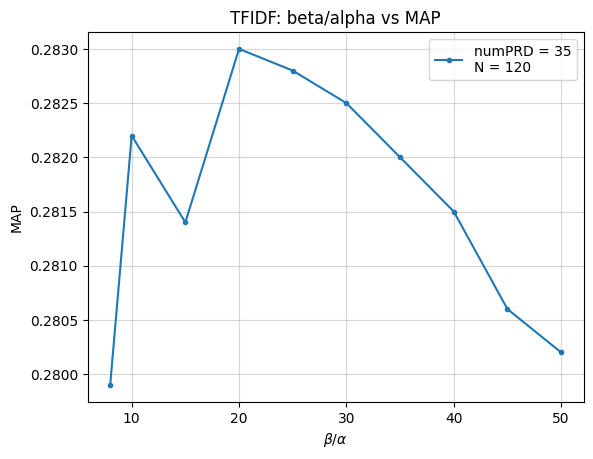

In [99]:
X = [ele[3]/ele[2] for ele in MAPs]     # beta/alpha
Y = [ele[4] for ele in MAPs]            # MAP values

# plt.semilogx(X, Y, '.', base=2,label=f'numPRD = {numPRD}\nN = {N}')
plt.plot(X,Y,'.-',label=f'numPRD = {numPRD}\nN = {N}')
plt.legend()
plt.title('TFIDF: beta/alpha vs MAP')
plt.xlabel(r'$\beta/\alpha$')
plt.ylabel('MAP')
plt.grid(alpha=0.5)
plt.savefig(f'./Rocchio_output/Rocchio TFIDF numPRD={numPRD} N={N} beta-alpha vs MAP plot.png', facecolor='white', transparent=False, dpi=300)
plt.show()

In [ ]:
# varying numPRD with beta/alpha ratio and N fixed

weightScheme = 'TFIDF'

N = 120
alpha = 1
beta = 40

numPRD_list = range(20,41,5)

for numPRD in numPRD_list:
    lmjm_rocchio(numPRD=numPRD,N=N,alpha=alpha,beta=beta,weightScheme=weightScheme)


import subprocess
import csv

f = open(f'./Rocchio_output/Rocchio_{weightScheme}_params_vs_MAP.tsv', 'a')
tsv_writer = csv.writer(f, delimiter='\t')
# tsv_writer.writerow(['method','numPRD','N','alpha','beta','MAP'])

MAPs = []

for numPRD in numPRD_list:
    rocchioOutputPath = f"./Rocchio_output/{weightScheme}/LMJM_Rocchio_#PRdocs={numPRD}_N={N}_alpha={alpha}_beta={beta}_{weightScheme}.res"
    result = subprocess.run(['trec_eval', 'trec678_robust.qrel', rocchioOutputPath], stdout=subprocess.PIPE)
    shell_output_string = result.stdout.decode('utf-8')
    if shell_output_string.split()[15] == 'map':
        map_value = float(shell_output_string.split()[17])
        MAPs.append([numPRD,N,alpha,beta,map_value])
        tsv_writer.writerow(['lmjm_0.4_rocchio',numPRD, N, alpha, beta, map_value])
    else:
        raise Exception('map_value index misalignment')
    
f.close()

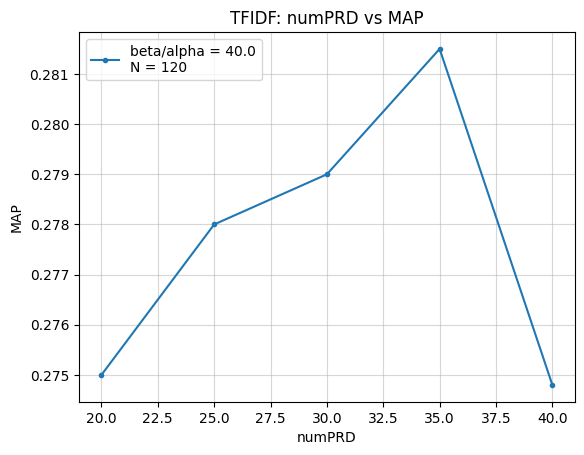

In [63]:
X = [ele[0] for ele in MAPs]     # numPRD values
Y = [ele[4] for ele in MAPs]     # MAP values

plt.plot(X,Y,'.-',label=f'beta/alpha = {beta/alpha}\nN = {N}')
plt.legend()
plt.title('TFIDF: numPRD vs MAP')
plt.xlabel('numPRD')
plt.ylabel('MAP')
plt.grid(alpha=0.5)
plt.savefig(f'./Rocchio_output/Rocchio TFIDF beta-alpha-ratio = {beta/alpha} N={N} numPRD vs MAP plot.png', facecolor='white', transparent=False, dpi=300)
plt.show()

In [ ]:
# varying N with beta/alpha ratio and numPRD fixed

weightScheme = 'TFIDF'

numPRD = 35
alpha = 1
beta = 45

N_list = range(50,181,10)

for N in N_list:
    lmjm_rocchio(numPRD=numPRD,N=N,alpha=alpha,beta=beta,weightScheme=weightScheme)


import subprocess
import csv

f = open(f'./Rocchio_output/Rocchio_{weightScheme}_params_vs_MAP.tsv', 'a')
tsv_writer = csv.writer(f, delimiter='\t')
# tsv_writer.writerow(['method','numPRD','N','alpha','beta','MAP'])

MAPs = []

for N in N_list:
    rocchioOutputPath = f"./Rocchio_output/{weightScheme}/LMJM_Rocchio_#PRdocs={numPRD}_N={N}_alpha={alpha}_beta={beta}_{weightScheme}.res"
    result = subprocess.run(['trec_eval', 'trec678_robust.qrel', rocchioOutputPath], stdout=subprocess.PIPE)
    shell_output_string = result.stdout.decode('utf-8')
    if shell_output_string.split()[15] == 'map':
        map_value = float(shell_output_string.split()[17])
        MAPs.append([numPRD,N,alpha,beta,map_value])
        tsv_writer.writerow(['lmjm_0.4_rocchio',numPRD, N, alpha, beta, map_value])
    else:
        raise Exception('map_value index misalignment')
    
f.close()

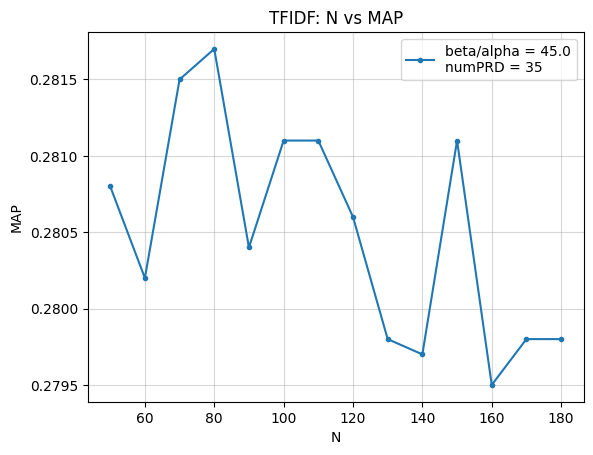

In [83]:
X = [ele[1] for ele in MAPs]     # N values
Y = [ele[4] for ele in MAPs]     # MAP values

plt.plot(X,Y,'.-',label=f'beta/alpha = {beta/alpha}\nnumPRD = {numPRD}')
plt.legend()
plt.title('TFIDF: N vs MAP')
plt.xlabel('N')
plt.ylabel('MAP')
plt.grid(alpha=0.5)
plt.savefig(f'./Rocchio_output/Rocchio TFIDF beta-alpha-ratio = {beta/alpha} numPRD={numPRD} N vs MAP plot.png', facecolor='white', transparent=False, dpi=300)
plt.show()